In [525]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df=pd.read_csv("tmdb_new.csv",parse_dates=['release_date'])
d=df #extra copy for doing yearly average calculation

,id,belongs_to_collection,budget,genres,imdb_id,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,cast,crew,revenue,timestamp
1944,685,NaN,160000000,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",tt2771200,A live-action adaptation of Disney's version o...,287.253654,/tWqifoYuwLETmmasnGHO7xBjEtt.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2017-03-16,129.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Be our guest.,Beauty and the Beast,"[{'cast_id': 174, 'character': 'Belle', 'credi...","[{'credit_id': '551879bec3a3681f840004eb', 'de...",1262886337,1.489622e+09
1957,519,"[{'id': 468552, 'name': 'Wonder Woman Collecti...",149000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0451279,An Amazon princess comes to the world of Man t...,294.337037,/imekS7f1OuHyUP2LAiTEM0zBzUz.jpg,"[{'name': 'Dune Entertainment', 'id': 444}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2017-05-30,141.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Power. Grace. Wisdom. Wonder.,Wonder Woman,NaN,NaN,820580447,1.496102e+09
1962,1696,NaN,34000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",tt3890160,After being coerced into working for a crime b...,228.032744,/dN9LbVNNZFITwfaRjl4tmwGWkRg.jpg,"[{'name': 'Big Talk Productions', 'id': 443}, ...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2017-06-28,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",All you need is one killer track.,Baby Driver,"[{'cast_id': 9, 'character': 'Baby', 'credit_i...","[{'credit_id': '55c58c009251417a21000e5d', 'de...",224511319,1.498608e+09


## Multivariate Regression on the TMDB dataset

In [507]:
Y=df[["budget","popularity","runtime","revenue"]] #this will be used for training and finding the outliers

#these 3 lines will remove outliers
#Y=Y[(np.abs(stats.zscore(Y)) < 5).all(axis=1)] #remove outliers because one outlier will ruin the entire regression
#outlier=df.drop(Y.index) #dataframe of outliers
#df=pd.merge(df,outlier, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [524]:
x=df.timestamp.values 
X = np.stack([x], axis=1) #for linear regression requiring 2D array
model = LinearRegression(fit_intercept=True)
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [509]:
print(model.coef_)

[[ 2.32629311e-02]
 [ 3.57513816e-09]
 [-3.38942675e-09]
 [ 5.66575427e-02]]


In [510]:
df['prediction0'] = df['timestamp']*model.coef_[0] + model.intercept_[0] #budget
df['prediction1'] = df['timestamp']*model.coef_[1] + model.intercept_[1] #popularity
df['prediction2'] = df['timestamp']*model.coef_[2] + model.intercept_[2] #runtime
df['prediction3'] = df['timestamp']*model.coef_[3] + model.intercept_[3] #revenue

Text(0.5, 1.0, 'Revenue Over Time')

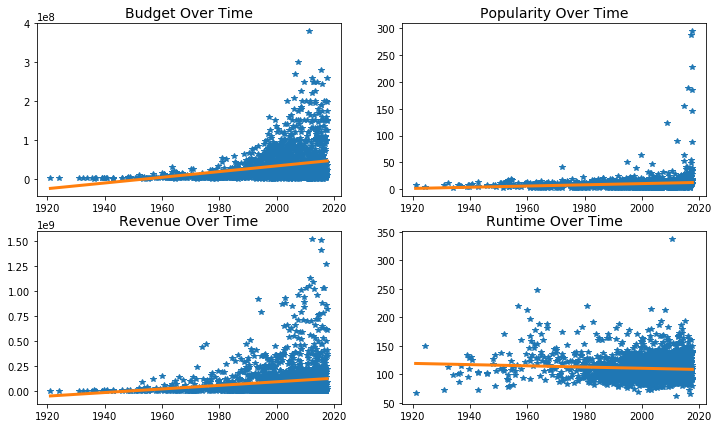

In [511]:

fig, axs = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(12)
axs[0,0].plot(df['release_date'],Y['budget'],'*')
axs[0,0].plot(df['release_date'],df['prediction0'], linewidth=3)
axs[0,0].set_title("Budget Over Time", fontsize = 14)

axs[0,1].plot(df['release_date'],Y['popularity'],'*')
axs[0,1].plot(df['release_date'],df['prediction1'], linewidth=3)
axs[0,1].set_title("Popularity Over Time", fontsize = 14)

axs[1,1].plot(df['release_date'],Y['runtime'],'*')
axs[1,1].plot(df['release_date'],df['prediction2'], linewidth=3)
axs[1,1].set_title("Runtime Over Time", fontsize = 14)

axs[1,0].plot(df['release_date'],Y['revenue'],'*')
axs[1,0].plot(df['release_date'],df['prediction3'], linewidth=3)
axs[1,0].set_title("Revenue Over Time", fontsize = 14)
#plt.xlabel("year", fontsize = 12)
#plt.ylabel("$ in 100 millions", fontsize = 12)
#plt.legend(["actual data","regression line"])

## Re-doing the regression but with averages

In [512]:
d=d[["budget","popularity","release_date","runtime","revenue","timestamp"]] #getting any variables we need

In [513]:
d=d.groupby(d['release_date'].dt.year)[d.columns].agg(['mean']) #grouping by year and getting averages
X_ = d.timestamp 
Y_ = d.drop(columns=["timestamp"])

In [514]:
model_ = LinearRegression(fit_intercept=True)
model_.fit(X_, Y_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [515]:
print(model_.coef_)

[[ 1.81936212e-02]
 [ 2.45254736e-09]
 [-2.11415726e-09]
 [ 4.84749817e-02]]


From model_.coef, it looks like the average of budget and revenue doesn't have a slope of zero

In [516]:
d['prediction0'] = d['timestamp']*model_.coef_[0] + model_.intercept_[0] #budget
d['prediction1'] = d['timestamp']*model_.coef_[1] + model_.intercept_[1] #popularity
d['prediction2'] = d['timestamp']*model_.coef_[2] + model_.intercept_[2] #runtime
d['prediction3'] = d['timestamp']*model_.coef_[3] + model_.intercept_[3] #revenue

Text(0.5, 1.0, 'Average Revenue Over Time')

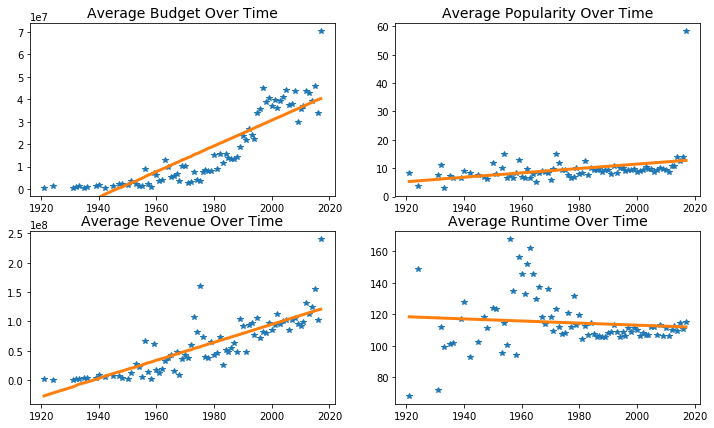

In [517]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(12)
axs[0,0].plot(d.index,Y_['budget'],'*')
axs[0,0].autoscale(enable=False)
axs[0,0].plot(d.index,d['prediction0'], linewidth=3)
axs[0,0].set_title("Average Budget Over Time", fontsize = 14)


axs[0,1].plot(d.index,Y_['popularity'],'*')
axs[0,1].plot(d.index,d['prediction1'], linewidth=3)
axs[0,1].set_title("Average Popularity Over Time", fontsize = 14)

axs[1,1].plot(d.index,Y_['runtime'],'*')
axs[1,1].plot(d.index,d['prediction2'], linewidth=3)
axs[1,1].set_title("Average Runtime Over Time", fontsize = 14)

axs[1,0].plot(d.index,Y_['revenue'],'*')
axs[1,0].plot(d.index,d['prediction3'], linewidth=3)
axs[1,0].set_title("Average Revenue Over Time", fontsize = 14)

In [518]:
from scipy import stats
reg_budget = stats.linregress(d.timestamp.values.flatten(), d.budget.values.flatten())
reg_pop = stats.linregress(d.timestamp.values.flatten(), d.popularity.values.flatten())
reg_runtime = stats.linregress(d.timestamp.values.flatten(), d.runtime.values.flatten())
reg_revenue = stats.linregress(d.timestamp.values.flatten(), d.revenue.values.flatten())
print("Probability of budget to have no correlation with time: ",reg_budget.pvalue)
print("Probability of popularity to have no correlation with time: ",reg_pop.pvalue)
print("Probability of runtime to have no correlation with time: ",reg_runtime.pvalue)
print("Probability of revenue to have no correlation with time: ",reg_revenue.pvalue)

Probability of budget to have no correlation with time:  1.1803230550600191e-26
Probability of popularity to have no correlation with time:  0.0027977256000317565
Probability of runtime to have no correlation with time:  0.37065399982854164
Probability of revenue to have no correlation with time:  5.850728773692394e-22


Budget and revenue data has a pvalue less than 0.05 so there is some relationship with time

In [519]:
print("Correlation coefficient of budget with time:" ,reg_budget.rvalue)
print("Correlation coefficient of popularity with time:", reg_pop.rvalue)
print("Correlation coefficient of runtime with time:" ,reg_runtime.rvalue)
print("Correlation coefficient of revenue with time:" ,reg_revenue.rvalue)

Correlation coefficient of budget with time: 0.8778430717135361
Correlation coefficient of popularity with time: 0.3299741907147155
Correlation coefficient of runtime with time: -0.10142977008946888
Correlation coefficient of revenue with time: 0.835286744590959


Budget and revenue has a correlation coefficient over 0.8, so it is a strong relation.

## Trying regression on critic and audience ratings

In [520]:
data = pd.read_csv('movies_success.csv',parse_dates=['publication_date'])
data=data.sort_values("publication_date")

In [521]:
xdata=data.publication_date
Ydata = data[["audience_average","audience_percent","critic_average","critic_percent"]]
Xdata = np.stack([xdata], axis=1) #for linear regression requiring 2D array
model = LinearRegression(fit_intercept=True)
model.fit(Xdata, Ydata)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [522]:
print(model.coef_)

[[ 5.44855356e-20]
 [-6.65425409e-18]
 [-6.13705577e-19]
 [-9.58138797e-18]]


The slope is about zero for all rating variables. 

Text(0, 0.5, 'rating')

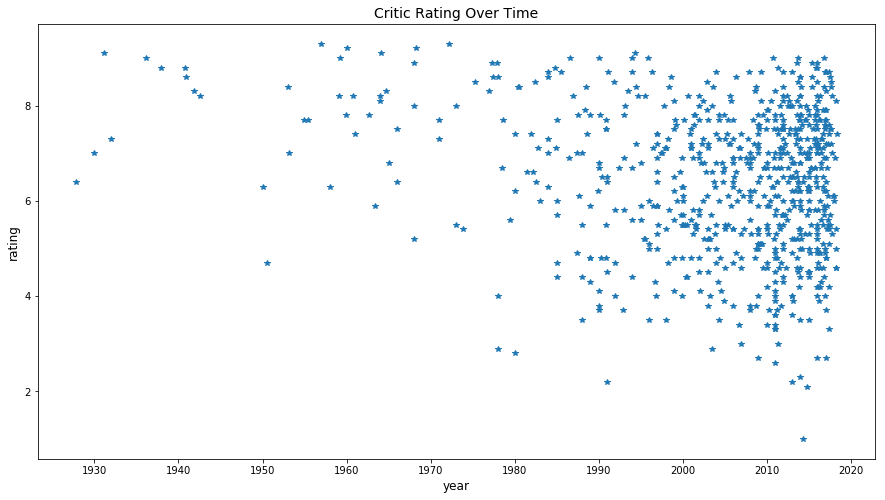

In [523]:
plt.figure(figsize=(15, 8)) # change the size to something sensible
plt.plot(data.publication_date,data['critic_average'],'*')
plt.title("Critic Rating Over Time", fontsize=14)
plt.xlabel("year", fontsize=12)
plt.ylabel("rating", fontsize=12)

There doesn't seem to be any correlation with rating and time